In [144]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
from matplotlib import cm
from matplotlib import colors as c
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters

In [145]:
specs,meta = Data.Spectra(sim='lgal',noise = 'none', lib = 'bc03', sample = 'mini_mocha')
photo, _ = Data.Photometry(sim='lgal', noise= 'none', lib='bc03', sample='mini_mocha') 
input_mass = meta['logM_total'][:10]

In [146]:
class convergence_plotter():
    def __init__(self,walkers,num_run,data_dir):
        self.num_walkers = walkers
        self.num_run = num_run
        self.data_dir = data_dir
        self.files = []
        
    def post(self):
        data = [x for x in self.files]
        
        return data
        
    def opener(self):
        f = [x for x in glob.glob(f'{self.data_dir}/*.hdf5')]  
        f.sort()
        print(f)
        files = []
        
        for i in f:
            file = h5py.File(i,'r')
            files.append(file)
        
        self.files = files
        return None
    def walker_perc_plot(self,spec_photo,step=1000, flag = ""):
        import seaborn as sns
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)
        
        for sample,idx in zip(data,range(num_gal)):
            plt.figure(figsize=(12,9))
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Median')
            plt.grid()
            plt.title(f'{spec_photo} galaxy {idx + 1} walker-percentile plot{flag}')
            plt.axhline(input_mass[idx], lw = 1, c = 'r')
            plt.text(1000,input_mass[idx],f'{input_mass[idx]}')
            #plt.xlim(-10000,None)
            
            colors = plt.cm.copper(np.linspace(0,1,self.num_walkers))            
            for i in range(self.num_walkers):
                y,up_perc,lo_perc = [], [], []
                length = len(sample)//self.num_walkers
                inc = length//step
                x_axis = (np.arange(inc)+1)*step
                for n in range(inc):
                    walker_sample = sample[i:step * (1+n):self.num_walkers]
                    up = np.percentile(walker_sample,84.1)
                    lo = np.percentile(walker_sample,15.9)
                    med = np.median(walker_sample)
                    up_perc.append(up-med)
                    lo_perc.append(med-lo)
                    y.append(med)
                    
                yerr = np.vstack((up_perc,lo_perc))
                plt.plot(x_axis,y,label= f'walker {i+1}',lw = 0.5,c = 'grey')#colors[i])
                plt.fill_between(x_axis, np.array(y)-np.array(lo_perc), np.array(y)+np.array(up_perc),color='gray', alpha=0.05)
                
            plt.savefig(f'Walker-Percentile plot galaxy {idx+1}{flag}.pdf', format = 'pdf')
            plt.show()
    
    def avg_perc_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)
        
        for sample,idx in zip(data,range(num_gal)):
            y,up_perc,lo_perc = [], [], []
            length = len(sample)
            inc = length//step
            x_axis = (np.arange(inc)+1)*step
            for n in range(inc):
                up = np.percentile(sample[:step*(1+n)],84.1)
                lo = np.percentile(sample[:step*(1+n)],15.9)
                med = np.median(sample[:step*(1+n)])
                up_perc.append(up-med)
                lo_perc.append(med-lo)
                y.append(med)
            
            yerr = np.vstack((up_perc,lo_perc))    
            plt.figure(figsize=(12,9))
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Median')
            plt.grid()
            plt.title(f'{spec_photo} galaxy {idx+1} percentile plot')
            plt.axhline(input_mass[idx], lw = 1, c = 'r')
            plt.text(1000,input_mass[idx],f'{input_mass[idx]}')
            plt.text(length,y[-1],f'{y[-1]}')
            plt.errorbar(x_axis,y,yerr=yerr,fmt = '.k', ecolor = 'gray', elinewidth=1,capsize=1)
            plt.xlim(-10000,None)
            plt.savefig(f'Percentile plot galaxy {idx+1}.pdf', format = 'pdf')
            plt.show()
    def hist_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal=len(data)
            
        for sample,idx in zip(data,range(num_gal)):
            length = len(sample)
            inc = length//step
            colors = plt.cm.copper_r(np.linspace(0,1,inc))
            plt.figure(figsize=(12,9))
            for n in range(inc):
                hist = plt.hist(sample[:(1+n)*step],bins=50,histtype='step',color=colors[n],density='True',linewidth=1.2)

            plt.xlabel('$log M*$')
            plt.ylabel('Frequency')
            plt.title(f'{spec_photo } galaxy {idx+1} histogram')
            norm = c.Normalize(vmin=1,vmax=length) #Upper and lower boundaries for the color bar
            cbar = plt.colorbar(cm.ScalarMappable(norm = norm, cmap=cm.copper_r))
            plt.show()
                      
        return None
    
    def GRD2(self,sample):
        M = self.num_walkers
        N = len(sample)//M
        r_sample = []
        for idx in range(self.num_walkers):
            r_sample.append(sample[idx::self.num_walkers])
        means = []
        sq_means = []
        
        for m in r_sample:

            means.append(np.mean(m))
            sq_means.append(np.mean(m**2))
            
        tot_mean = np.mean(means)
        B = N*np.sum((means-tot_mean)**2)/(M-1)
        W = np.sum(sq_means-np.square(means))/M
        p_var = W*(N-1)/N+(M+1)*B/(M*N)
        PSRF = p_var/W

        return PSRF
    
        
    def GRD(self,sample):
        M = self.num_walkers
        N = len(sample)//M
        r_sample = np.reshape(sample,(M,N))
        means = [] #For E(X)
        sq_means = [] #For E(X^2)

        for m in r_sample:
            means.append(np.mean(m))
            sq_means.append(np.mean(m**2))

        tot_mean = np.mean(means)
        B = N*np.sum((means-tot_mean)**2)/(M-1)
        W = np.sum(sq_means-np.square(means))/M
        p_var = W*(N-1)/N+(M+1)*B/(M*N)
        PSRF = p_var/W


        return PSRF

    def PSRF_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)

        for sample,idx in zip(data,range(num_gal)):
            PSRFs = []
            length = len(sample)
            inc = length//step
            x_axis = np.arange(inc)*step
            plt.figure(figsize=(12,9))
            for n in range(inc):
                PSRFs.append(self.GRD2(sample[:(1+n)*step]))
            
            plt.plot(x_axis,PSRFs, c = 'k', lw = 2)
            plt.axhline(1.1, c = 'r', ls = '--', lw = 1)
            plt.ylim(0,None)
            plt.xlim(0,None)
            plt.grid()
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Potential Scale Reduction Factor (PSRF)')
            plt.title(f'{spec_photo} galaxy {idx+1} PSRF plot')
            plt.savefig(f'{spec_photo} galaxy {idx+1} PSRF plot.pdf', format = 'pdf')
            plt.show()


            

NM0_max = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM0/')
NM1_max = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM1/')
NM2_max = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM2/')
NM3_max = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM3/')
NM4_max = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM4/')
NM5_max = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM5/')
NM6_max = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM6/')
NM7_max = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM7/')
NM8_max = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM8/')
NM9_max = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM9/')

NM0_100 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM0/')
NM1_100 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM1/')
NM2_100 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM2/')
NM3_100 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM3/')
NM4_100 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM4/')
NM5_100 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM5/')
NM6_100 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM6/')
NM7_100 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM7/')
NM8_100 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM8/')
NM9_100 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM9/')
NMs_100 = [NM0_100,NM1_100,NM2_100,NM3_100,NM4_100,NM5_100,NM6_100,NM7_100,NM8_100,NM9_100]
NMs_max = [NM0_max,NM1_max,NM2_max,NM3_max,NM4_max,NM5_max,NM6_max,NM7_max,NM8_max,NM9_max]
for nm,nm2 in zip(NMs_max,NMs_100):
    nm.opener()
    nm2.opener()

['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM0/NM0.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM0/NM0.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM1/NM1.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM1/NM1.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM2/NM2.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM2/NM2.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM3/NM3.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_100/NM3/NM3.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test3/max_none/NM4/NM4.hdf5']
['/Users/james

In [147]:
gal1_mass = input_mass[0]
walker = np.arange(20)+1
def get_init_pos(method,name):
    data = method.post()
    init_pos = data[0]['mcmc_chain'][...][:,0]
    return {name : init_pos}

def plot_resid2_gal(data_list, data_list2, label1, label2):
    method = []
    mean = []
    method2 = []
    mean2 = []
    
    for i,elem in enumerate(data_list):
        method.append(list(elem.keys())[0])
        mean.append(np.mean(np.abs(list(elem.values())[0]-input_mass[i])))
    
    for i,elem in enumerate(data_list2):
        method2.append(list(elem.keys())[0])
        mean2.append(np.mean(np.abs(list(elem.values())[0]-input_mass[i])))
    x = np.arange(len(method))  # the label locations
    width = 0.40  # the width of the bars
    fig, ax = plt.subplots(figsize=(8,5))
    rects = ax.bar(x-width/2, mean, width, color = 'lightblue', label = label1)
    rects = ax.bar(x+width/2, mean2, width, color = 'steelblue', label = label2)
    ax.set_ylabel('Difference')
    ax.set_title('Difference between initial positions and the truth')
    ax.set_xticks(x)
    ax.set_xticklabels(method)
    ax.legend()
    
NMs_max_pos = [get_init_pos(nm,f'NM{i}') for i, nm in enumerate(NMs_max)]
NMs_100_pos = [get_init_pos(nm,f'NM{i}') for i, nm in enumerate(NMs_100)]

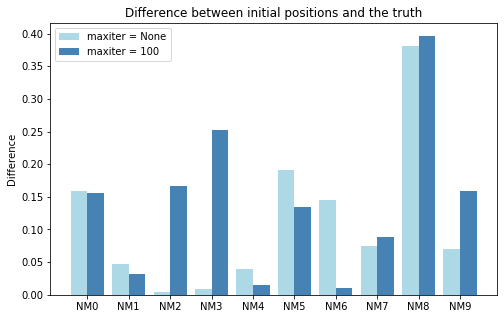

In [148]:
plot_resid2_gal(NMs_max_pos,NMs_100_pos,'maxiter = None', 'maxiter = 100')#, flag = '_maxiter_none_defx10')
plt.savefig('Difference_maxiter.pdf', format = 'pdf')
# plot_resid2_gal(NMs_100_pos)#, flag = '_maxiter_100_defx10')

In [149]:
T = {}
IT = {}
T_0 = {}
IT_0 = {}

In [150]:
T['NM0']= 80.154575536
IT['NM0'] = 373
T['NM1']= 107.258212669
IT['NM1'] = 729
T['NM2']= 140.90225638500002
IT['NM2'] = 751
T['NM3']= 105.80309959800002
IT['NM3'] = 733
T['NM4'] = 88.69378899999998
IT['NM4'] =466
T['NM5'] = 102.92089205800005
IT['NM5'] = 704
T['NM6'] = 137.1300313229999
IT['NM6'] = 729
T['NM7'] = 114.36286717099995
IT['NM7'] = 410
T['NM8'] = 106.36845882299997
IT['NM8'] = 719
T['NM9'] = 136.20568747100003
IT['NM9'] = 747

In [151]:
T_0['NM0']= 64.634372893
IT_0['NM0'] = 100
T_0['NM1']= 64.69043555500001
IT_0['NM1'] = 100
T_0['NM2']= 95.261715791
IT_0['NM2'] = 100
T_0['NM3']= 65.669668564
IT_0['NM3'] = 100
T_0['NM4'] = 66.17203806999999
IT_0['NM4'] = 100
T_0['NM5'] = 65.67929729300005
IT_0['NM5'] = 100
T_0['NM6'] = 66.61886564599996
IT_0['NM6'] = 100
T_0['NM7'] = 68.34706287100005
IT_0['NM7'] = 100
T_0['NM8'] = 65.79268074499998
IT_0['NM8'] = 100
T_0['NM9'] = 63.42389246799996
IT_0['NM9'] = 100

In [152]:
def comp_time(ax,t1, t2, l1, l2):
    T1 = []
    T2 = []
    methods = []
    for t1_item, t2_val in zip(t1.items(),t2.values()):
        t1_key,t1_val = t1_item
        T1.append(t1_val)
        T2.append(t2_val)
        methods.append(t1_key)
    x = np.arange(len(T1))
    width = 0.2
    rect1 = ax.bar(x+width/2,T1,width, label = l1, color = 'lightblue')
    rect2 = ax.bar(x-width/2,T2,width, label = l2, color = 'steelblue')
    ax.set_xticklabels(methods)
    ax.set_xticks(np.arange(10))
    ax.set_ylabel('Computation Time')
    ax.grid()
    ax.legend(loc = 'upper right')
def comp_v(ax,t1,it1,t2,it2,l1,l2):
    v1 = []
    v2 = []
    methods = []
    for it1_item, it2_val,t1_val,t2_val in zip(it1.items(),it2.values(),t1.values(),t2.values()):
        it1_key,it1_val = it1_item
        v1.append(it1_val/t1_val)
        v2.append(it2_val/t2_val)
        methods.append(it1_key)
    x = np.arange(len(v1))
    width = 0.2
    rect1 = ax.bar(x+width/2,v1,width, label = l1, color = 'lightblue')
    rect2 = ax.bar(x-width/2,v2,width, label = l2, color = 'steelblue')
    ax.set_xticklabels(methods)
    ax.set_xticks(np.arange(10))
    ax.set_ylabel('Computatio Speed')
    ax.grid()
    ax.legend(loc = 'upper right')

def it(ax,it1,it2,l1,l2):
    It1 = []
    It2 = []
    methods = []
    for it1_item, it2_val in zip(it1.items(),it2.values()):
        it1_key,it1_val = it1_item
        It1.append(it1_val)
        It2.append(it2_val)
        methods.append(it1_key)
    x = np.arange(len(It1))
    width = 0.2
    rect1 = ax.bar(x+width/2,It1,width, label = l1, color = 'lightblue')
    rect2 = ax.bar(x-width/2,It2,width, label = l2, color = 'steelblue')
    ax.set_xticklabels(methods)
    ax.set_xticks(np.arange(10))
    ax.set_ylabel('$N_{Iteration}$')
    ax.grid()
    ax.legend(loc = 'upper right')

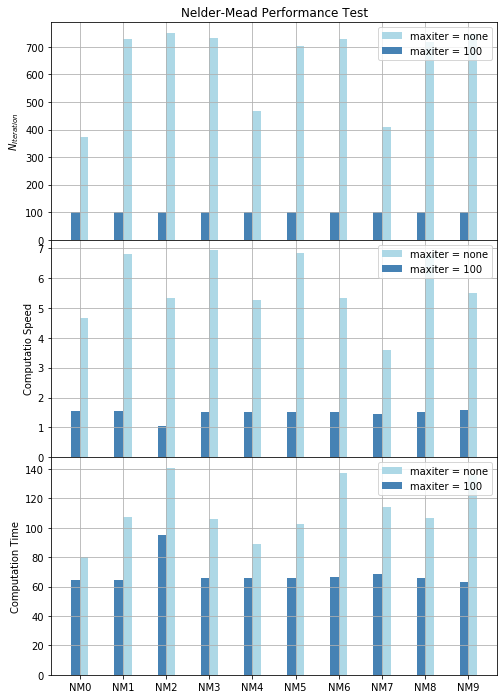

In [153]:
fig, axs = plt.subplots(3,1,figsize=(8,12), sharex = True)
axs[0].set_title('Nelder-Mead Performance Test')
fig.subplots_adjust(hspace = 0)
it(axs[0],IT,IT_0,'maxiter = none',  'maxiter = 100')
comp_v(axs[1],T,IT,T_0,IT_0,'maxiter = none',  'maxiter = 100')
comp_time(axs[2],T,T_0,'maxiter = none',  'maxiter = 100')
fig.savefig('NM_performance.pdf', format = 'pdf')